In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ctd
import gsw

# execute a linha de comando abaixo para fazer download do conjunto de dados que serão utilizados
#!wget --directory-prefix=../dados/ https://github.com/ocefpaf/pyrantine/raw/master/notebooks/02-CTD/CTD-data/CTD-spiked-unfiltered.cnv.bz2

# lendo um arquivo .cnv, formato vindo do CTD da marca Seabird
cast = ctd.from_cnv('../dados/CTD-spiked-unfiltered.cnv.bz2')

down,up = cast.split()

down_final = down.remove_above_water()\
            .lp_filter()\
            .despike(n1=2, n2=20, block=100)\
            .press_check()\
            .interpolate()\
            .bindata(delta=1)\
            .smooth(window_len=21, window="hanning")

# extraindo metadados
metadados = cast._metadata

# extraindo pressao que é um índice
pressao = down_final.index

lon,lat = metadados['lon'], metadados['lat']


# Salinidade Prática
SP = gsw.SP_from_C(down_final['c0S/m']*10, 
                   down_final['t090C'], 
                   pressao)

# Salinidade Absoluta
SA = gsw.SA_from_SP(SP, pressao, lon, lat)

# Temperatura conservativa
CT = gsw.CT_from_t(SA, 
                   down_final['t090C'].values,
                   pressao)

# Profundidade a partir da pressão
z = -gsw.z_from_p(pressao, lat)

# Anomalia da densidade potensial
sigma0 = gsw.sigma0(SA, CT)

down_final = down_final.assign(SP=SP, 
                               SA=SA, 
                               CT=CT,
                               z=z,
                               sigma0=sigma0)


In [ ]:
# se você teve problemas para importar o pacote GSW ou CTD, 
# é pq precisa instalar:
!pip install python-ctd
!pip install gsw

In [ ]:
# com climatologia do WOA
woa_temp = pd.read_csv('../dados/temperatura_woa2018_ubatuba_60m.csv', sep=',')
woa_salt = pd.read_csv('../dados/salinidade_woa2018_ubatuba_60m.csv', sep=',')

# construir matriz de profundidade para usar como cores
depth = woa_temp.iloc[:,0].values
ndepth = np.tile(depth, (12,1)).T

# para facilitar, extrair informações de T e S 
T = woa_temp.iloc[:,1:].values
S = woa_salt.iloc[:,1:].values

# visualização
fig,ax = plt.subplots()
cs = ax.scatter(S, T, c=ndepth)
cbar = plt.colorbar(cs)
cbar.set_label('Prof [m]')
ax.set_xlabel('Salinidade [psu]')
ax.set_ylabel('Temperatura [oC]')

In [ ]:
# extraindo algumas variáveis que nos ajudarão
minT,maxT = down_final['CT'].min(), down_final['CT'].max()
minS,maxS = down_final['SA'].min(), down_final['SA'].max()

dep = down_final['z'].values

In [ ]:
# usando os maximos e minimos, criamos matrizes de T e S
T = np.linspace(minT-1, maxT+1., 100)
S = np.linspace(minS-0.1, maxS+0.1, 100)

# convertemos as matrizes 1D para 2D em forma de malha (grid)
T,S = np.meshgrid(T,S)

# calculamos uma grade de densidades paramétricas
dens = gsw.sigma0(S,T)

fig,ax=plt.subplots()

# contorno de densidades
cs = ax.contour(S, T, dens, colors='grey', zorder=1)

# identificando as linhas de densidade
cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f')

# inserindo os pares de TS
sc = plt.scatter(down_final['SA'],
               down_final['CT'], 
               c=dep,s=10)

# customizando o gráfico
cb = plt.colorbar(sc)
cb.set_label('Profundidade [m]')
ax.set_xlabel('Salinidade [psu]')
ax.set_ylabel(r'Temperatura [$^o$C]')

# 5 - Pandas ... seu lindo!

![](https://media.istockphoto.com/photos/panda-with-tongue-out-picture-id184987985?k=6&m=184987985&s=170667a&w=0&h=xldV1zkI-b3zfWBOcS9vpgI4k5LlbbhakKFlbWgqtRk=)

**material de apoio**

## Análise de série temporal

Uma série temporal consiste em uma **sequência de informações** (dados observados, modelados, reanálise), ordenados por um **eixo temporal**.

Normalmente, espera-se que a série temporal tenha pontos igualmente espaçados no tempo, mas nem sempre este será o caso. Cabe, portanto, ao cientista que estiver analisando esta informação, explorar o conjunto de dados, não só em busca de outliers, mas também em busca de inconsistênciasna estrutura do conjunto de dados.

A partir desta identificação, poderemos ajustar nosso conjunto de modo a, de fato, trabalhar com ele.

**Eixo temporal (DatetimeIndex)**

Dentro deste contexto, precisamos entender como o **pandas** trabalha com o eixo temporal. Esta é uma importante característica em um DataFrame, que nos permitirá realizar ações poderosas de forma simples e intuitiva.

Porém, como nem tudo são rosas, trabalhar com datas e horas no python pode ser um pouco complicado de início, mas melhora com o tempo.

O próprio pandas possui algumas ferramentas muito espertas para se trabalhar com *datetime*, porém o python ainda possui outras ferramentas que complementam um arsenal de pacotes para lidar com essa importante informação.

Dentre as ferramentas disponíveis, citaremos três:

- datetime
- dateutils
- pandas

In [7]:
# importando os pacotes
import datetime
import dateutil
import pandas as pd

# criando algumas variáveis
agora = datetime.datetime.now()

# checando o tipo de variável
print(type(agora))
# visualizando a data. Já renderizada para o padrão internacional
print(agora)

<class 'datetime.datetime'>
2020-11-10 06:40:05.347611


Uma vez que temos variáveis no formato ```datetime.datetime```, podemos realizar diversas operações com essa informação, como por exemplo adicionar ou subtrair dias, horas, segundos, etc com o método ```timedelta```:

In [9]:
ontem = agora - datetime.timedelta(days=1)
print(ontem)

ontem = agora - datetime.timedelta(hours=24)
print(ontem)

ontem = agora - datetime.timedelta(seconds=86400)
print(ontem)

2020-11-09 06:40:05.347611
2020-11-09 06:40:05.347611
2020-11-09 06:40:05.347611


In [123]:
amanha = agora + datetime.timedelta(days=1)
print(amanha)

amanha = agora + datetime.timedelta(hours=24)
print(amanha)

amanha = agora + datetime.timedelta(seconds=86400)
print(amanha)

2020-11-11 06:40:05.347611
2020-11-11 06:40:05.347611
2020-11-11 06:40:05.347611


Enquanto trabalharmos em termos de análise de dados, é mais adequado utilizarmos o formato de datetime ```YYYY-mm-dd HH:MM:SS```. No entanto, quando queremos criar nossas visualizações ou apenas exibir informações no padrão brasileiro, podemos utilizar o método ```.strftime()``` para formatar a saída da nossa data. Assim teremos total controle no formato que queremos exibir. Vejamos:

In [18]:
# todas as datas em decimais
print(agora.strftime('%d/%m/%Y %H:%M:%S'))

10/11/2020 06:40:05


In [19]:
# mês abreviado
print(agora.strftime('%d/%b/%Y %H:%M:%S'))

10/Nov/2020 06:40:05


In [20]:
# dia da semana
print(agora.strftime('%A'))

Tuesday


In [23]:
# número do dia no ano 
print(agora.strftime('%j'))

315


Mais opções de formatação podem ser encontradas em: https://strftime.org/

Podemos, em algum momento, nos deparar com arquivos excel em que a data está preenchida de forma legível aos humanos, mas não tão legível para um computador. Por exemplo:

```10 Jan 2001 13:15:00```

Neste caso, o pacote ```datetime``` não consegue converter esta informação no tipo de variável que estamos querendo chegar. Assim, utilizamos nesstas ocasiões o pacote ```dateutil.parser.parse``` para resolver este problema:

In [26]:
data_baguncada = '10 Jan 2001 13:15:00'

In [27]:
datetime.datetime(data_baguncada)

TypeError: an integer is required (got type str)

In [29]:
data = dateutil.parser.parse(data_baguncada)
print(type(data_baguncada))
print(type(data))
print(data)

<class 'str'>
<class 'datetime.datetime'>
2001-01-10 13:15:00


**Mas como trabalhar com datas em uma série temporal longa?**

Até agora vimos casos específicos de uma variável apenas. Agora, vamos observar como lidar com o tempo em uma série de dados mais longa. 

O próprio pandas possui muitas ferramentas para lidar com o eixo temporal dos arquivos que pode ler. Porém, os métodos variam a depender da estrutura do arquivo a ser lido.

Vamos utilizaro conjunto de dados da PNBOIA Vitória, do [Programa Nacional de Boias](https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia).

 No caso deste conjunto de dados, podemos implementar dois métodos para criar um eixo temporal bem estruturado, visto que o próprio arquivo nos fornece dois tipos de informação de tempo:

- coluna **# Epoca**: que contabiliza o tempo, em segundos, a partir de uma data de referência. Esta data deve ser conhecida e, geralmente, é utilizado ```1970-01-01 00 (UTC)```. 

- columnas de tempo (year, month, etc): neste caso, precisamos recriar manualmente, porém a informação será a mesma.

Vejamos:

In [46]:
# lendo algumas colunas do arquivo PNBOIA Vitoria
df = pd.read_csv('../dados/pnboia_vitoria.csv', 
                 usecols=[0,3,4,5, 6, 7])

df.head()

,# Epoca,Year,Month,Day,Hour,Minute
0,1444755600,2015,10,13,17,21
1,1444759200,2015,10,13,18,21
2,1444762800,2015,10,13,19,21
3,1444766400,2015,10,13,20,21
4,1444770000,2015,10,13,21,21


**Primeiro método**: convertendo *Epoch*/*timestamp*

In [42]:
# extraindo primeira linha para facilitar a visualização apenas
linha1 = df.iloc[0:1]
linha1

,# Epoca,Year,Month,Day,Hour,Minute
0,1444755600,2015,10,13,17,21


Usando o pacote ```datetime.datetime.fromtimestamp()``` para converter o **Epoch** (também conhecido como *timestamp*):

In [44]:
datetime.datetime\
            .fromtimestamp(linha1['# Epoca'])\
            .strftime('%Y-%m-%d %H:%M:%S')

'2015-10-13 14:00:00'

Porém, notem a diferença de hora. A conversão deixou já considerou a nossa localização e atribuiu o fuso horário adequado. Enquanto que no arquivo CSV original, a data ainda está em UTC.

**Segundo método**: convertendo as colunas

Em muitas ocasiões, o tempo poderá ser dado em diversas colunas, contendo o ano, mês, dia, etc. Nestes casos, podemos converter essas diversas colunas em uma única coluna de *datetime*.

Para isso, precisamos utilizar dois argumentos na leitura do arquivo (csv, excel):

```date_parser```: uma função criada para converter as diversas colunas em apenas uma única coluna

```parse_dates```: especificamos quais colunas alimentarão a função.

In [29]:
# funcao: será utilizada no date_parser
def dateparse(x):
    return pd.datetime.strptime(x, '%Y %m %d %H %M')

# podemos usar funções lambda
# dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')

df = pd.read_csv('../dados/pnboia_vitoria.csv',
                 parse_dates={'datetime': ['Year', 'Month', 'Day', 'Hour', 'Minute']},
                 date_parser=dateparse,
                 decimal=',',
                 )

df.head()

,datetime,# Epoca,Lat,Lon,Battery,bHead,Wspd,Wspdflag,Wspdflagid,Wdir,...,Wmax,Wmaxflag,Wmaxflagid,Dpd,Dpdflag,Dpdflagid,Mwd,Mwdflag,Mwdflagid,Spred
0,2015-10-13 17:21:00,1444755600,-19.935850,-39.704233,-9999.0,98.66,11.409288,0,0,52,...,2.54,0,0,8.0,0,0,63,0,0,31.3
1,2015-10-13 18:21:00,1444759200,-19.935883,-39.704183,-9999.0,98.36,11.083308,0,0,52,...,2.31,0,0,8.7,0,0,67,0,0,31.2
2,2015-10-13 19:21:00,1444762800,-19.936000,-39.704100,-9999.0,97.30,11.843927,0,0,51,...,3.09,0,0,8.7,0,0,59,0,0,31.1
3,2015-10-13 20:21:00,1444766400,-19.936133,-39.703967,-9999.0,99.90,13.582485,0,0,55,...,3.06,0,0,6.1,0,0,57,0,0,32.9
4,2015-10-13 21:21:00,1444770000,-19.936117,-39.703933,-9999.0,96.21,12.387227,0,0,49,...,2.73,0,0,5.6,0,0,53,0,0,32.7


Notem que o dataframe agora não possui mais as colunas referentes aos tempos (Year, Month, etc) e uma nova coluna foi criada (```datetime```).

A partir desta coluna nova, podemos transformá-la em ```index``` para finalizar a preparação da nossa série temporal:

In [30]:
df.set_index('datetime', inplace=True)
df.head()

,# Epoca,Lat,Lon,Battery,bHead,Wspd,Wspdflag,Wspdflagid,Wdir,Wdirflag,...,Wmax,Wmaxflag,Wmaxflagid,Dpd,Dpdflag,Dpdflagid,Mwd,Mwdflag,Mwdflagid,Spred
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-13 17:21:00,1444755600,-19.935850,-39.704233,-9999.0,98.66,11.409288,0,0,52,0,...,2.54,0,0,8.0,0,0,63,0,0,31.3
2015-10-13 18:21:00,1444759200,-19.935883,-39.704183,-9999.0,98.36,11.083308,0,0,52,0,...,2.31,0,0,8.7,0,0,67,0,0,31.2
2015-10-13 19:21:00,1444762800,-19.936000,-39.704100,-9999.0,97.30,11.843927,0,0,51,0,...,3.09,0,0,8.7,0,0,59,0,0,31.1
2015-10-13 20:21:00,1444766400,-19.936133,-39.703967,-9999.0,99.90,13.582485,0,0,55,0,...,3.06,0,0,6.1,0,0,57,0,0,32.9
2015-10-13 21:21:00,1444770000,-19.936117,-39.703933,-9999.0,96.21,12.387227,0,0,49,0,...,2.73,0,0,5.6,0,0,53,0,0,32.7


**Criando eixo temporal do zero**

Eventualmente precisaremos criar um eixo de tempo do zero, apenas tendo informações como:
- data de início
- data final 
- frequência temporal 

Para fazer isso, usamos mais um método do pandas, chamado ```pd.date_range()```:

In [53]:
# frequência horária
eixo_temporal = pd.date_range(start='2020-10-20', 
                              end='2020-11-20',
                              freq='H')
eixo_temporal

DatetimeIndex(['2020-10-20 00:00:00', '2020-10-20 01:00:00',
               '2020-10-20 02:00:00', '2020-10-20 03:00:00',
               '2020-10-20 04:00:00', '2020-10-20 05:00:00',
               '2020-10-20 06:00:00', '2020-10-20 07:00:00',
               '2020-10-20 08:00:00', '2020-10-20 09:00:00',
               ...
               '2020-11-19 15:00:00', '2020-11-19 16:00:00',
               '2020-11-19 17:00:00', '2020-11-19 18:00:00',
               '2020-11-19 19:00:00', '2020-11-19 20:00:00',
               '2020-11-19 21:00:00', '2020-11-19 22:00:00',
               '2020-11-19 23:00:00', '2020-11-20 00:00:00'],
              dtype='datetime64[ns]', length=745, freq='H')

In [54]:
# frequência diária
eixo_temporal = pd.date_range(start='2020-10-20', 
                              end='2020-11-20',
                              freq='D')
eixo_temporal

DatetimeIndex(['2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27',
               '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31',
               '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20'],
              dtype='datetime64[ns]', freq='D')

In [57]:
# frequência quinzenal
eixo_temporal = pd.date_range(start='2020-10-20', 
                              end='2020-11-20',
                              freq='15D')
eixo_temporal

DatetimeIndex(['2020-10-20', '2020-11-04', '2020-11-19'], dtype='datetime64[ns]', freq='15D')

**Vamos visualizar essa série temporal**

<AxesSubplot:xlabel='datetime'>

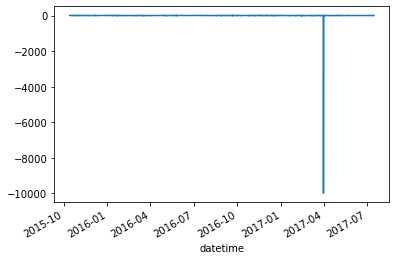

In [88]:
df['Wspd'].plot()

Infelizmente, temos claramente um momento com dados extremamente anômalo (outlier) em relação às demais variáveis.

Podemos identificar este valor utilizando o método ```.min()``` e depois substituir este valor com o método ```.replace()```.

In [89]:
df['Wspd'].min()

-9999.0

In [31]:
df = df.replace(-9999, np.nan)

<AxesSubplot:xlabel='datetime'>

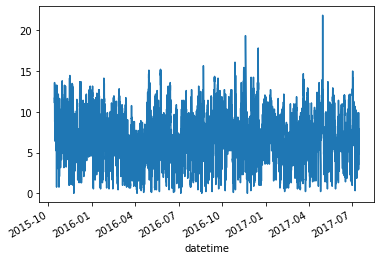

In [91]:
df['Wspd'].plot()

**Filtrando dados pelo tempo**

Uma vez que temos o eixo temporal bem construído, podemos filtrar nossa série temporal utilizando o próprio tempo como controle:

<AxesSubplot:xlabel='datetime'>

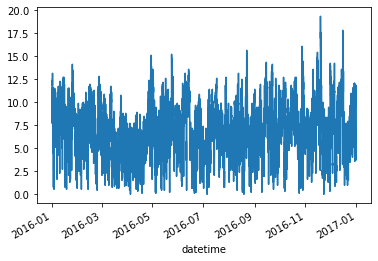

In [95]:
# plotando nintensidade do vento para o ano de 2016
df['2016']['Wspd'].plot()

<AxesSubplot:xlabel='datetime'>

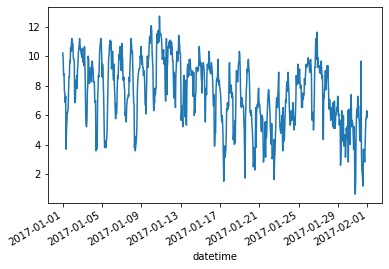

In [96]:
# intensidade do vento para Janeiro de 2017
df['2017-01']['Wspd'].plot()

**Agrupamento (groupby)**

Ainda, podemos agrupar os dados. Neste caso, especificamente, podemos agrupar temporalmente, mas em outros casos podemos utilizar outros critérios de agrupamento.

Sintaxe geral:

```pythn
df.groupby(by='', axis=0).sum()
```

- by: determina os grupos quer serão quebrados (split). São chamadas de chaves (keys)
- axis: agrupar por linhas (axis=0) ou por coluna (axis=1)
- sum: neste caso como exemplo, usamos a média do grupo, mas podemos utilizar qualquer método estatístico já visto (max, min, sum, etc).

![](https://camo.githubusercontent.com/eaa4d59f0d7edf93a6d04918dce79d902c305534/68747470733a2f2f7374617469632e7061636b742d63646e2e636f6d2f70726f64756374732f393738313738333938353132382f67726170686963732f353132384f535f30395f30312e6a7067)

<AxesSubplot:xlabel='datetime'>

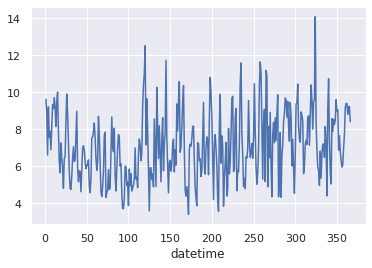

In [32]:
# calculando a climatologia diária da intensidade do vento
df['Wspd'].groupby(df.index.dayofyear).mean().plot()

<AxesSubplot:xlabel='datetime'>

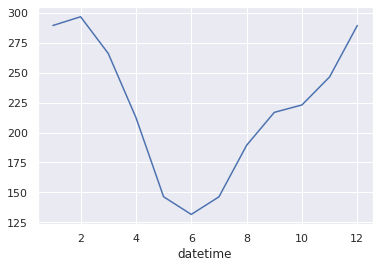

In [33]:
# calculando a climatologia mensal da radiação solar
df['Arad'].groupby(df.index.month).mean().plot()

<AxesSubplot:xlabel='datetime'>

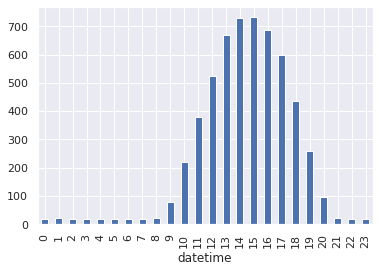

In [34]:
# média horária de radiação solar
df['Arad'].groupby(df.index.hour).mean().plot(kind='bar')

**Reamostragem (resample)**

Reamostrar, temporalmente, a série temporal.

```python

df.resample(rule).mean()
```

In [116]:
# reamostrar para média diária
df.resample('D').mean()['Wspd'].head()

datetime
2015-10-13    11.937064
2015-10-14     9.969544
2015-10-15    10.499261
2015-10-16    10.911263
2015-10-17     8.719956
Freq: D, Name: Wspd, dtype: float64

<AxesSubplot:xlabel='datetime'>

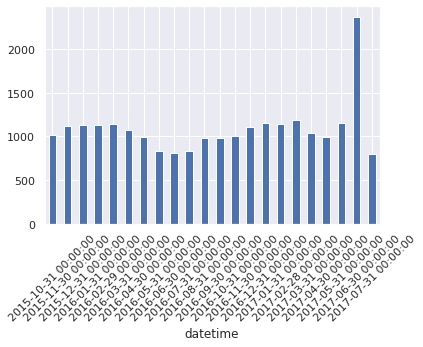

In [35]:
# reamostrar para máximo mensal
df.resample('M').max()['Arad'].plot(kind='bar', rot=45)

Podemos, ainda, computar a correlação entre duas ou mais colunas de um mesmo dataframe, usando o método ```.corr()```:

,Wtmp,Atmp
Wtmp,1.00000,0.81464
Atmp,0.81464,1.00000


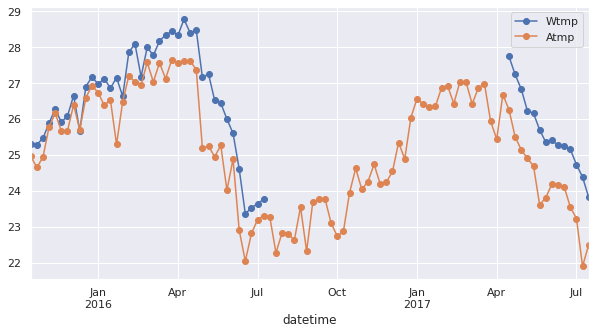

In [36]:
#existe correlação entre temperatura da superfície do mar e do ar?
df[['Wtmp', 'Atmp']].resample("W").mean()\
                    .plot(style="-o",
                          figsize=(10, 5))

df[['Wtmp', 'Atmp']].corr()

### Algumas visualizações bacanas

Podemos utilizar um outro pacote para montar visualizações bem interessantes dos datasets. Este pacote, ```seaborn```, permite inclusive realizar alguns cálculos de regressão linear, regressão logística, etc.

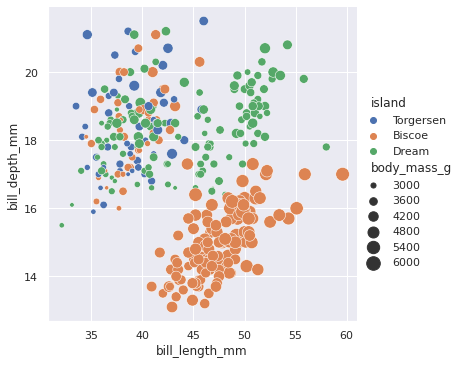

In [5]:
# padrão de importar
import seaborn as sns
# podemos mudar o tema do fundo dos gráficos pra ficar mais legal
sns.set_theme(style="darkgrid")

# carregando um dataset que vem instalado, sobre pinguins!
species = sns.load_dataset('penguins')

# uma primeira visualização já bem interessante e completa
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

g = sns.relplot(
    data=species,
    x="bill_length_mm", y="bill_depth_mm",
    hue="island", size="body_mass_g", sizes=(10, 200),
)

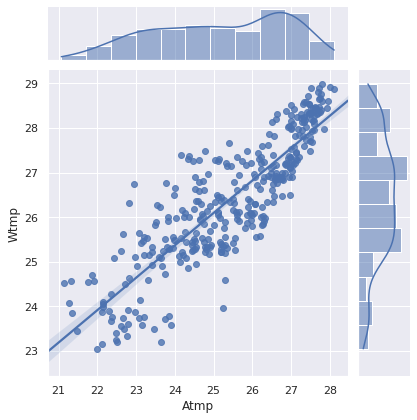

In [37]:
# regressão linear com distribuição marginal utilizando o conjunto do PNBOIA
data = df.resample('D').mean().reset_index()

g = sns.jointplot(x='Atmp', y='Wtmp', data=data, kind='reg', truncate=False)

No exemplo acima, conseguimos concentrar 4 informações em um único gráfico, relacionando o comprimento e altura do bico do pinguim (plano cartesiano), o peso total do corpo do pinguim (tamanho dos marcadores) e as espécies (em cores).

Nos exemplos a seguir, usaremos um conjunto de dados de salmão capturados no Oceano Pacífico Norte e disponibilizado em https://www.bco-dmo.org/dataset/3106.

In [40]:
# carregando dataset de salmão capturados no Pacífico Norte: https://www.bco-dmo.org/dataset/3106
fish = pd.read_csv('https://erddap.bco-dmo.org/erddap/tabledap/bcodmo_dataset_3106.csv',
                  dtype={'haul_id': int, 'weight_wet': float, 'length_wet': float, 'depth_w': float,
                         'sex': str, 'maturity': str, 'species_common_name': str},
                  skiprows=[1,2],
                  usecols=[0, 3, 9, 10, 12, 14, 15, 16])

# reduzindo o tamanho
fish = fish[fish['year'] == 2001]

fish.head()

,year,haul_id,depth_w,species_common_name,length_wet,weight_wet,sex,maturity
0,2001,2001001,64.0,Chum,698.0,4108.0,M,A
1,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
2,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
3,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
4,2001,2001001,64.0,Chum,NaN,NaN,NaN,J


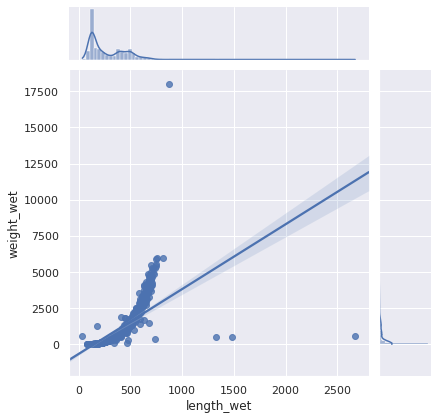

In [41]:
# peso x comprimento com regressão linear ajustada e a distribuição 
g = sns.jointplot(x="length_wet", y="weight_wet",
                  data=fish, kind='reg', truncate=False)

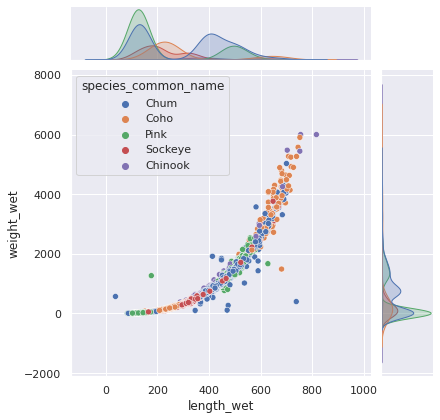

In [42]:
fish[(fish['length_wet'] > 1000)] = np.nan
fish[(fish['weight_wet'] > 10000)] = np.nan

# peso x comprimento com regressão linear ajustada e a distribuição 
g = sns.jointplot(x="length_wet", y="weight_wet", hue="species_common_name", 
                  data=fish)

Podemos ainda utilizar agrupamento para visualizar a quantidade de indivíduos em cada espécie:

<AxesSubplot:xlabel='species_common_name'>

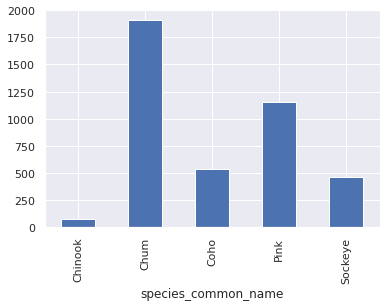

In [43]:
# quantidade de indivíduos por espécie
fish.groupby('species_common_name').count().plot(kind='bar', y='year', legend=False)

Sempre que estamos trabalhando com contagem, precisamos tomar cuidado com valores NaN, que podem inserir um erro nos nossos cálculos. Optem sempre por utilizar funções que **não** consideram NaN nos cálculos. Sendo, portanto, necessário entender as funções antes de utiliza-las, lendo sua documentação. 

Vejam um caso em que há diferença:

In [44]:
fish.groupby('maturity').count()

,year,haul_id,depth_w,species_common_name,length_wet,weight_wet,sex
maturity,,,,,,,
A,473,473,466,473,473,473,461
I,915,915,727,915,915,914,908
J,2750,2750,2750,2750,2242,2242,21


In [45]:
fish.dropna(axis=0, how='any').groupby('maturity').count()

,year,haul_id,depth_w,species_common_name,length_wet,weight_wet,sex
maturity,,,,,,,
A,454,454,454,454,454,454,454
I,719,719,719,719,719,719,719
J,21,21,21,21,21,21,21


No primeiro caso, não há concordância entre as colunas no total de indivíduos. Isso ocorre pois algumas colunas possuem valores nan que são computados na contagem. Quando removemos estas linhas com ao menos uma ocorrência de NaN, obtemos um resultado homogêneo. 

## Introdução aos exercícios

Com tudo que foi construído até agora, podemos realizar análises de dados tabulares utilizando as ferramentas Pandas e Seaborn, além de, se necessário, trabalhar com informações de CTD e computar propriedades hidrográficas com base nas convenções TEOS-10.

Hoje, vamos começar a ver como ler um arquivo excel, fazer alguns ajustes necessários, para extrairmos valiosas informações relacionadas às manchas de petróleo que afetaram o litoral nordeste brasileiro em 2019.

O conjunto de dados, fornecido pelo IBAMA, pode ser baixado em:

Porém aqui iremos ler direto como um dataframe, utilizando o método ```pd.read_excel()```.

Responda:

- Utilizando groupby, count e plot, monte um gráfico de barras e responda: qual o Estado mais afetado segundo o conjunto de dados?

- Da mesma forma, mas sem necessidade de figura, agrupe por Município e apresente quais foram os 10 mais afeatdos

- Filtre o conjunto de dados para identificar as primeiras e últimas localidades afetadas.

- Por fim, qual a localidade afetada por mais tempo?

In [128]:
url = "http://www.ibama.gov.br/phocadownload/emergenciasambientais/2019/manchasdeoleo/2019-12-02_LOCALIDADES_AFETADAS.xlsx"
df = pd.read_excel(
    url,
    parse_dates=["Data_Avist", "Data_Revis"],
)

# Calculando o tempo de permanência da mancha em cada localidade
df["dias"] = (df["Data_Revis"] - df["Data_Avist"]).dt.days

# tratando as colunas de tempo
df['Data_Avist'] = df['Data_Avist'].dt.strftime('%Y-%m-%d').str.replace('NaT', 'na')
df["Data_Revis"] = df["Data_Revis"].dt.strftime("%Y-%m-%d").str.replace("NaT", "na")
df["dias"] = df["dias"].astype('Int64').astype(str).str.replace("nan", "na")

df.dropna(inplace=True)
df.head()

,geocodigo,localidade,loc_id,municipio,estado,sigla_uf,Data_Avist,Data_Revis,Status,Latitude,Longitude,dias
0,3201605,Praia de Guriri,3201605_43,Conceição da Barra,Espírito Santo,ES,2019-11-23,2019-11-23,Oleada - Vestigios / Esparsos,"18° 40' 43.70"" S","39° 44' 33.69"" W",0
1,3201605,Praia de Guriri,3201605_46,Conceição da Barra,Espírito Santo,ES,2019-11-18,2019-11-19,Oleada - Vestigios / Esparsos,"18° 42' 14.87"" S","39° 44' 45.92"" W",1
2,3201605,Praia de Guriri,3201605_45,Conceição da Barra,Espírito Santo,ES,2019-11-21,2019-11-27,Oleada - Vestigios / Esparsos,"18° 41' 54.57"" S","39° 44' 40.31"" W",6
3,2207702,Praia do Pontal,2207702_4,Parnaíba,Piauí,PI,2019-11-08,2019-11-17,Oleada - Vestigios / Esparsos,"2° 45' 46.58"" S","41° 46' 54.03"" W",9
4,3202405,Praia do Morro,3202405_39,Guarapari,Espírito Santo,ES,2019-11-28,2019-11-28,Oleada - Vestigios / Esparsos,"20° 39' 18.19"" S","40° 28' 42.74"" W",0


### Outro exercício

Para quem quiser avançar um pouco na visualização de dados, vamos ver como criar wind rose (diagramas direcionais) com dados de direção de corrente, vento e ondas.

Para isso, utilizaremos o conjunto de dados do PNBOIA Vitória. 

1. Vá ao site da Marinha Brasileira [[link]](https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia)
2. Baie o arquivo de metadados para o PNBOIA
3. Identifique as colunas correspondentes a:
    - direção e intensidade do vento
    - direção e intensidade da corrente próximo a superfície
    - direção e altura significativa de onda
    
4. Com as informações acima, monte três dataframes com essas informações, classificadas para três variáveis (vento, corrente e onda), todas indexadas pelo tempo

5. Utilizando o pacote ```windrose```, monte os diagramas direcionais para as variáveis.

Nota: atente-se para as convenções matemática, oceanográfica e meteorológica na hora de plotar. O pacote ```windrose``` possui um argumento para lidar com a definição das convenções meteorológicas. Procura na documentação do pacote por esse argumento: [[link]](https://windrose.readthedocs.io/)

In [137]:
# para instalar o windrose no Google-Colab, use:
!pip install windrose

In [128]:
import windrose